In [1]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten,BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from random import seed
from random import randint


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report as cr

Using TensorFlow backend.


In [2]:
seed = 16
filename = '../fer2013.csv'
label_map = ['Enfado', 'Asco', 'Miedo', 'Alegria', 'Tristeza', 'Sorpresa', 'Neutral']
label_map = np.array(label_map)
names=['emocion','pixels','uso']
df=pd.read_csv(filename,names=names, na_filter=False)
im=df['pixels']
df.head(10)

,emocion,pixels,uso
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [3]:
def loadData(filname):
    
    Y_train = []
    X_train = []
    Y_test = []
    X_test = []
    
    first = True
    uso = 'Training\n'
    for line in open(filname):
        if first:
            first = False
        else:
            row = line.split(',')
            condition = str(row[2])
            if condition == 'Training\n':
                Y_train.append(int(row[0]))
                X_train.append([int(p) for p in row[1].split()])
            else:
                Y_test.append(int(row[0]))
                X_test.append([int(p) for p in row[1].split()])
                
    X_train, Y_train = np.array(X_train)/255.0 , np.array(Y_train)
    X_test, Y_test = np.array(X_test)/255.0 , np.array(Y_test)

    return X_train, X_test, Y_train, Y_test 

In [4]:
X_train, X_test, Y_train, Y_test= loadData(filename)

In [5]:
N_train = X_train.shape[0]
N_test = X_test.shape[0]
X_train = X_train.reshape(N_train, 48, 48,1)
X_test = X_test.reshape(N_test, 48, 48,1)

In [6]:
# one hot encode output
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
class_num = Y_test.shape[1]

In [7]:
model = Sequential()

model.add(Conv2D(6,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'tanh'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(16,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'tanh'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='tanh',kernel_constraint=maxnorm(3)))
model.add(Dense(class_num, activation='softmax',kernel_constraint=maxnorm(3)))

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
model.summary()
optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 6)         156       
_________________________________________________________________
average_pooling2d_1 (Average (None, 22, 22, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 9, 9, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1296)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               166016    
_________________________________________________________________
dense_2 (Dense)              (None, 7)                

In [10]:
epochs = 100

es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mc = ModelCheckpoint('.ln5_1.hdf5', save_best_only=True, monitor='val_loss', mode='min')
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')

np.random.seed(16)
cb =  [es,mc,rlr]
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

Instructions for updating:
Use tf.cast instead.
Train on 28709 samples, validate on 7178 samples
Epoch 1/100
28709/28709 [==============================] - 42s 1ms/step - loss: 1.6829 - accuracy: 0.3413 - val_loss: 1.6374 - val_accuracy: 0.3643
Epoch 2/100
28709/28709 [==============================] - 40s 1ms/step - loss: 1.6330 - accuracy: 0.3626 - val_loss: 1.6258 - val_accuracy: 0.3692
Epoch 3/100
28709/28709 [==============================] - 40s 1ms/step - loss: 1.6213 - accuracy: 0.3703 - val_loss: 1.6181 - val_accuracy: 0.3760
Epoch 4/100
28709/28709 [==============================] - 40s 1ms/step - loss: 1.6151 - accuracy: 0.3749 - val_loss: 1.6171 - val_accuracy: 0.3823
Epoch 5/100
28709/28709 [==============================] - 40s 1ms/step - loss: 1.6103 - accuracy: 0.3765 - val_loss: 1.6195 - val_accuracy: 0.3732
Epoch 6/100
28709/28709 [==============================] - 40s 1ms/step - loss: 1.6021 - accuracy: 0.3789 - val_loss: 1.6168 - val_accuracy: 0.3713
Epoch 7/100
287

In [9]:
model.load_weights('.ln5_1.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)




In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    fig, ax = plt.subplots(figsize = (5,5))
  
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(-0.5, 6.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix
[[ 783    0   10  111   22   10   22]
 [  97    4    1    6    2    0    1]
 [ 796    0   40   76   33   45   34]
 [ 723    0    2 1003   26   10   10]
 [ 977    0    7  114  102    6   41]
 [ 432    0    7   51    6  327    8]
 [ 896    0    7  134   27   11  158]]


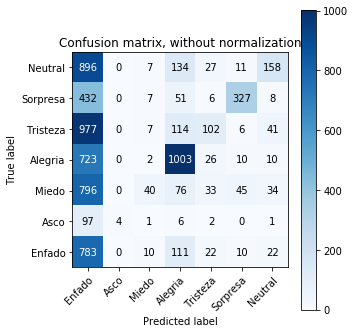

In [11]:
plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)

In [12]:
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))


              precision    recall  f1-score   support

      Enfado       0.17      0.82      0.28       958
        Asco       1.00      0.04      0.07       111
       Miedo       0.54      0.04      0.07      1024
     Alegria       0.67      0.57      0.61      1774
    Tristeza       0.47      0.08      0.14      1247
    Sorpresa       0.80      0.39      0.53       831
     Neutral       0.58      0.13      0.21      1233

    accuracy                           0.34      7178
   macro avg       0.60      0.29      0.27      7178
weighted avg       0.55      0.34      0.32      7178



In [13]:
model = Sequential()

model.add(Conv2D(6,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(16,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_constraint=maxnorm(3)))
model.add(Dense(class_num, activation='softmax',kernel_constraint=maxnorm(3)))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 44, 44, 6)         156       
_________________________________________________________________
average_pooling2d_3 (Average (None, 22, 22, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 16)        2416      
_________________________________________________________________
average_pooling2d_4 (Average (None, 9, 9, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1296)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               166016    
_________________________________________________________________
dense_4 (Dense)              (None, 7)                

In [19]:


mc = ModelCheckpoint('.ln5_2.hdf5', save_best_only=True, monitor='val_loss', mode='min')
cb =  [es,mc,rlr]

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)


Train on 28709 samples, validate on 7178 samples
Epoch 1/100
28709/28709 [==============================] - 42s 1ms/step - loss: 1.6709 - accuracy: 0.3421 - val_loss: 1.5765 - val_accuracy: 0.3906
Epoch 2/100
28709/28709 [==============================] - 41s 1ms/step - loss: 1.5260 - accuracy: 0.4142 - val_loss: 1.4870 - val_accuracy: 0.4259
Epoch 3/100
28709/28709 [==============================] - 43s 1ms/step - loss: 1.4458 - accuracy: 0.4444 - val_loss: 1.4421 - val_accuracy: 0.4466
Epoch 4/100
28709/28709 [==============================] - 42s 1ms/step - loss: 1.3791 - accuracy: 0.4709 - val_loss: 1.4165 - val_accuracy: 0.4539
Epoch 5/100
28709/28709 [==============================] - 42s 1ms/step - loss: 1.3202 - accuracy: 0.4975 - val_loss: 1.3632 - val_accuracy: 0.4778
Epoch 6/100
28709/28709 [==============================] - 44s 2ms/step - loss: 1.2706 - accuracy: 0.5174 - val_loss: 1.3334 - val_accuracy: 0.4851
Epoch 7/100
28709/28709 [==============================] - 47s 

Confusion matrix
[[ 764    1   32   57   27   24   53]
 [  97    8    0    3    1    1    1]
 [ 676    0  122   54   41   75   56]
 [ 533    0   12 1124   16   40   49]
 [ 892    0   33   88  120   14  100]
 [ 274    0   22   25    4  493   13]
 [ 724    1   12   90   30   16  360]]
              precision    recall  f1-score   support

      Enfado       0.19      0.80      0.31       958
        Asco       0.80      0.07      0.13       111
       Miedo       0.52      0.12      0.19      1024
     Alegria       0.78      0.63      0.70      1774
    Tristeza       0.50      0.10      0.16      1247
    Sorpresa       0.74      0.59      0.66       831
     Neutral       0.57      0.29      0.39      1233

    accuracy                           0.42      7178
   macro avg       0.59      0.37      0.36      7178
weighted avg       0.58      0.42      0.41      7178



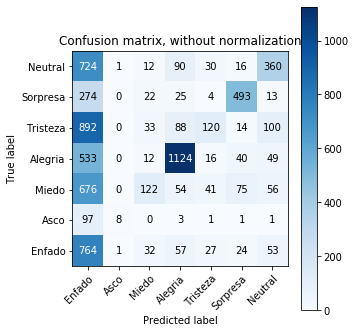

In [14]:
model.load_weights('.ln5_2.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)


plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))

In [15]:
model = Sequential()

model.add(Conv2D(6,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_constraint=maxnorm(3)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(class_num, activation='softmax',kernel_constraint=maxnorm(3)))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 44, 44, 6)         156       
_________________________________________________________________
dropout_1 (Dropout)          (None, 44, 44, 6)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 6)         24        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 18, 16)        2416      
_________________________________________________________________
dropout_2 (Dropout)          (None, 18, 18, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 18, 16)       

In [22]:


mc = ModelCheckpoint('.ln5_3.hdf5', save_best_only=True, monitor='val_loss', mode='min')
cb =  [es,mc,rlr]

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

Train on 28709 samples, validate on 7178 samples
Epoch 1/100
28709/28709 [==============================] - 64s 2ms/step - loss: 1.7672 - accuracy: 0.3510 - val_loss: 2.0141 - val_accuracy: 0.2885
Epoch 2/100
28709/28709 [==============================] - 62s 2ms/step - loss: 1.4559 - accuracy: 0.4381 - val_loss: 1.4308 - val_accuracy: 0.4558
Epoch 3/100
28709/28709 [==============================] - 62s 2ms/step - loss: 1.3752 - accuracy: 0.4713 - val_loss: 1.4536 - val_accuracy: 0.4323
Epoch 4/100
28709/28709 [==============================] - 61s 2ms/step - loss: 1.3301 - accuracy: 0.4903 - val_loss: 1.3744 - val_accuracy: 0.4677
Epoch 5/100
28709/28709 [==============================] - 62s 2ms/step - loss: 1.2726 - accuracy: 0.5121 - val_loss: 1.3383 - val_accuracy: 0.4859
Epoch 6/100
28709/28709 [==============================] - 62s 2ms/step - loss: 1.2326 - accuracy: 0.5315 - val_loss: 1.2864 - val_accuracy: 0.5056
Epoch 7/100
28709/28709 [==============================] - 61s 

Confusion matrix
[[ 706    0   29   65   77   12   69]
 [  70   28    1    7    2    0    3]
 [ 592    2  157   56  110   44   63]
 [ 384    0   11 1270   37   16   56]
 [ 695    0   30   88  315    6  113]
 [ 247    0   29   43   13  474   25]
 [ 578    1   14   87   70    5  478]]
              precision    recall  f1-score   support

      Enfado       0.22      0.74      0.33       958
        Asco       0.90      0.25      0.39       111
       Miedo       0.58      0.15      0.24      1024
     Alegria       0.79      0.72      0.75      1774
    Tristeza       0.50      0.25      0.34      1247
    Sorpresa       0.85      0.57      0.68       831
     Neutral       0.59      0.39      0.47      1233

    accuracy                           0.48      7178
   macro avg       0.63      0.44      0.46      7178
weighted avg       0.61      0.48      0.49      7178



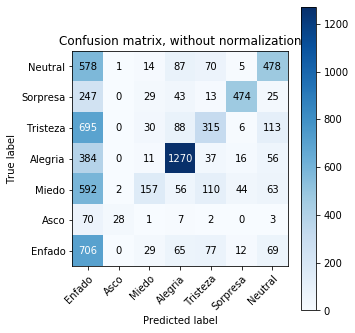

In [16]:
model.load_weights('.ln5_3.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)


plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))

In [17]:
X_train, X_test, Y_train, Y_test= loadData(filename)
X_train = X_train.reshape(N_train, 48, 48)

In [18]:
def mirror(img):
    copy = img.copy()
    indx = range(copy.shape[1]-1, -1, -1)
    copy = np.flip(copy, axis = 1)
    return copy


def random_erasing(img):
    copy = img.copy()
    numero_parches=(randint(1,3))
    for i in range(numero_parches):
        tam_h = randint(5,15)
        tam_v = randint(5,15)   
        start_h = randint(0,copy.shape[1]-tam_h)
        start_v = randint(0,copy.shape[0]-tam_v) 
        for i in range(tam_v):
            for j in range(tam_h):
                copy[start_v+i, start_h+j] = 1
    return copy


def tras_x(img, tras):
    order = []
    for i in range(tras):
        order = order + [0]
    order = order + list(range(img.shape[1]- tras))
    copy = img[:,order]
    return copy


def tras_y(img, tras):
    order = []
    for i in range(tras):
        order = order + [0]
    order = order + list(range(img.shape[0]- tras))
    copy = img[order,:]
    return copy

In [8]:
nuevo = []
etiquetas = []


for i in range(N_train):
    
    if np.random.random() < 0.5:
        n = mirror(X_train[i])
        nuevo += [n]
        etiquetas += [Y_train[i]]
        
    if np.random.random() < 0.5:
        if np.random.random() < 0.5:
            n = tras_x(X_train[i],randint(5,15))
        else:
            n = tras_y(X_train[i],randint(5,10))
        nuevo += [n]
        etiquetas += [Y_train[i]]
        
    if np.random.random() < 0.25:
        n = random_erasing(X_train[i])
        nuevo += [n]
        etiquetas += [Y_train[i]]
        

    
    
if len(etiquetas) > 0: 
    nuevo = np.array(nuevo)
    etiquetas =  np.array(etiquetas)
    X_train= np.append(X_train,nuevo,axis=0)
    Y_train = np.append(Y_train, etiquetas)

In [19]:
N_train = X_train.shape[0]
N_test = X_test.shape[0]
X_train = X_train.reshape(N_train, 48, 48,1)
X_test = X_test.reshape(N_test, 48, 48,1)
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)
class_num = Y_test.shape[1]

In [20]:
model = Sequential()

model.add(Conv2D(6,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16,(5,5),input_shape=X_train.shape[1:],padding = 'valid', strides = 1, activation = 'relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu',kernel_constraint=maxnorm(3)))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(class_num, activation='softmax',kernel_constraint=maxnorm(3)))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 44, 44, 6)         156       
_________________________________________________________________
dropout_4 (Dropout)          (None, 44, 44, 6)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 44, 44, 6)         24        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 22, 22, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 16)        2416      
_________________________________________________________________
dropout_5 (Dropout)          (None, 18, 18, 16)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 18, 18, 16)       

In [16]:
mc = ModelCheckpoint('.ln5_dau.hdf5', save_best_only=True, monitor='val_loss', mode='min')

cb =  [es,mc,rlr]
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks = cb)

Instructions for updating:
Use tf.cast instead.
Train on 64727 samples, validate on 7178 samples
Epoch 1/100
64727/64727 [==============================] - 136s 2ms/step - loss: 1.7333 - accuracy: 0.3351 - val_loss: 1.5819 - val_accuracy: 0.3877
Epoch 2/100
64727/64727 [==============================] - 135s 2ms/step - loss: 1.5064 - accuracy: 0.4136 - val_loss: 1.4609 - val_accuracy: 0.4397
Epoch 3/100
64727/64727 [==============================] - 136s 2ms/step - loss: 1.4219 - accuracy: 0.4498 - val_loss: 1.3531 - val_accuracy: 0.4755
Epoch 4/100
64727/64727 [==============================] - 137s 2ms/step - loss: 1.3620 - accuracy: 0.4762 - val_loss: 1.3903 - val_accuracy: 0.4652
Epoch 5/100
64727/64727 [==============================] - 138s 2ms/step - loss: 1.3241 - accuracy: 0.4923 - val_loss: 1.5714 - val_accuracy: 0.4448
Epoch 6/100
64727/64727 [==============================] - 139s 2ms/step - loss: 1.2921 - accuracy: 0.5062 - val_loss: 1.3142 - val_accuracy: 0.4978
Epoch 7/1

Confusion matrix
[[ 804    2    9   50   53    7   33]
 [  76   22    1    6    6    0    0]
 [ 691    4  117   38   88   50   36]
 [ 444    1    3 1249   27   22   28]
 [ 825    0   12   40  295    8   67]
 [ 306    1   14   42    6  454    8]
 [ 721    0    2   61   59    6  384]]
              precision    recall  f1-score   support

      Enfado       0.21      0.84      0.33       958
        Asco       0.73      0.20      0.31       111
       Miedo       0.74      0.11      0.20      1024
     Alegria       0.84      0.70      0.77      1774
    Tristeza       0.55      0.24      0.33      1247
    Sorpresa       0.83      0.55      0.66       831
     Neutral       0.69      0.31      0.43      1233

    accuracy                           0.46      7178
   macro avg       0.66      0.42      0.43      7178
weighted avg       0.66      0.46      0.47      7178



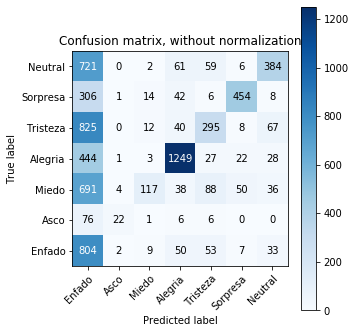

In [21]:
model.load_weights('.ln5_dau.hdf5')
pred = np.array(model.predict(X_test))
pred = np.around(pred)
pred = pred.astype(int)
Y_test = Y_test.astype(int)



plot_confusion_matrix(Y_test.argmax(axis=1),pred.argmax(axis=1),label_map)
print(cr(Y_test.argmax(axis=1),pred.argmax(axis=1),target_names = label_map))